In [57]:
import pandas as pd
import numpy as np

# Data pre-processing
import nltk
# List of stop words used for data pre-processing
from stop_words_list import stop_words_list
from nltk.corpus import stopwords

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topics modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [58]:
# List of available creators: "MKBHD", "Jonathan Morrison", "Unbox Therapy", "Chris Stuckman", "Jeremy Jahns", "Channel Awesome", "James Charles", "NikkieTutorials", "sophdoeslife"

creator = "MKBHD"
output_df = pd.read_excel(f"../comments_spreadsheets/extracted_comments_{creator}.xlsx")

In [59]:
duplicates = output_df[output_df.duplicated(("Comments"))]
print ("Count of duplicate comments in dataframe"
, duplicates.shape[0])

print ("Count of unique comments in dataframe"
, output_df.shape[0] - duplicates.shape[0])

# Remove duplicated comments from dataset
unique_df = output_df.drop_duplicates(subset=["Comments"], keep='first', ignore_index=True)
df = unique_df
# df = unique_df.reset_index()

# Removes line return "\n"
df = df.replace(r'\n',' ', regex=True)

# display(unique_df)
display(df)

Count of duplicate comments in dataframe 75
Count of unique comments in dataframe 1925


,Video ID,Comments
0,eWI_BtcDJu0,I like the blue this time. But will wait for 1...
1,eWI_BtcDJu0,I love to watch reviews of my phone just to co...
2,eWI_BtcDJu0,If you are planning to keep your phone for abo...
3,eWI_BtcDJu0,I've been watching an endless amount of videos...
4,eWI_BtcDJu0,Another fantastic review! Thank you mr Marcus....
...,...,...
1920,eWI_BtcDJu0,“Maybe you have kids that run far away” Why ...
1921,eWI_BtcDJu0,people who use spotify on iPhones are a differ...
1922,eWI_BtcDJu0,9:40 Hmmmmm..... something is off in this shot...
1923,eWI_BtcDJu0,"John Cena and Marques in sync... ""Are you sure..."


# Sentiment Analysis

In [60]:
sentimentAnalyser = SentimentIntensityAnalyzer()
sentimentScoreList = []
sentimentLabelList = []

for i in df["Comments"].values.tolist():
    sentimentScore = sentimentAnalyser.polarity_scores(i)

    if sentimentScore['compound'] >= 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Positive')
    elif sentimentScore['compound'] > -0.05 and sentimentScore['compound'] < 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Neutral')
    elif sentimentScore['compound'] <= -0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Negative')

df["Sentiment"] = sentimentLabelList
df["Sentiment Score"] = sentimentScoreList

display(df)

,Video ID,Comments,Sentiment,Sentiment Score
0,eWI_BtcDJu0,I like the blue this time. But will wait for 1...,Positive,0.6652
1,eWI_BtcDJu0,I love to watch reviews of my phone just to co...,Positive,0.8442
2,eWI_BtcDJu0,If you are planning to keep your phone for abo...,Positive,0.3612
3,eWI_BtcDJu0,I've been watching an endless amount of videos...,Positive,0.0982
4,eWI_BtcDJu0,Another fantastic review! Thank you mr Marcus....,Positive,0.9901
...,...,...,...,...
1920,eWI_BtcDJu0,“Maybe you have kids that run far away” Why ...,Positive,0.5777
1921,eWI_BtcDJu0,people who use spotify on iPhones are a differ...,Neutral,0.0000
1922,eWI_BtcDJu0,9:40 Hmmmmm..... something is off in this shot...,Neutral,0.0000
1923,eWI_BtcDJu0,"John Cena and Marques in sync... ""Are you sure...",Positive,0.3182


# Data Pre-Processing for LDA Model
1. Lowercase the letters
2. Remove the punctuation
3. Remove the number
4. Remove extra whitespaces
5. Tokenisation
6. Remove the stopwords

In [61]:
# Convert case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
# Lowercase all the letters
df['lower'] = df['Comments'].str.lower()

# Remove punctuations
df['punctuation_removed'] = df['lower'].str.replace("'", '', regex=True).str.replace('[^\w\s]', ' ', regex=True)

# Remove numbers
df['numbers_removed'] = df['punctuation_removed'].str.replace(" \d+", " ", regex=True)

# Remove extra whitespace
df['extra_spaces_removed'] = df['numbers_removed'].str.replace(' +', ' ', regex=True).str.strip()

# Tokenise
df['tokenised'] = df.apply(lambda row: nltk.word_tokenize(row['extra_spaces_removed']), axis=1)

# Stop words removal
# Initiate stopwords from nltk
stop_words = stopwords.words('english')

# Add additional missing terms
stop_words.extend(stop_words_list)

# Remove stopwords
df['removed_stopwords'] = df['tokenised'].apply(lambda x: [item for item in x if item not in stop_words])

display(df.head(10))

,Video ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords
0,eWI_BtcDJu0,I like the blue this time. But will wait for 1...,Positive,0.6652,i like the blue this time. but will wait for 1...,i like the blue this time but will wait for 1...,i like the blue this time but will wait for ...,i like the blue this time but will wait for an...,"[i, like, the, blue, this, time, but, will, wa...","[blue, time, wait, pro, upgrade]"
1,eWI_BtcDJu0,I love to watch reviews of my phone just to co...,Positive,0.8442,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,"[i, love, to, watch, reviews, of, my, phone, j...","[watch, reviews, phone, convince, worthy, purc..."
2,eWI_BtcDJu0,If you are planning to keep your phone for abo...,Positive,0.3612,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,"[if, you, are, planning, to, keep, your, phone...","[planning, keep, phone, years, pro, pick]"
3,eWI_BtcDJu0,I've been watching an endless amount of videos...,Positive,0.0982,i've been watching an endless amount of videos...,ive been watching an endless amount of videos ...,ive been watching an endless amount of videos ...,ive been watching an endless amount of videos ...,"[ive, been, watching, an, endless, amount, of,...","[watching, endless, amount, videos, decide, pr..."
4,eWI_BtcDJu0,Another fantastic review! Thank you mr Marcus....,Positive,0.9901,another fantastic review! thank you mr marcus....,another fantastic review thank you mr marcus ...,another fantastic review thank you mr marcus ...,another fantastic review thank you mr marcus t...,"[another, fantastic, review, thank, you, mr, m...","[fantastic, review, marcus, difference, featur..."
5,eWI_BtcDJu0,Those intro shots man 👌,Positive,0.7297,those intro shots man 👌,those intro shots man,those intro shots man,those intro shots man,"[those, intro, shots, man]","[intro, shots, man]"
6,eWI_BtcDJu0,@Marques it would be interesting to also inclu...,Positive,0.9337,@marques it would be interesting to also inclu...,marques it would be interesting to also inclu...,marques it would be interesting to also inclu...,marques it would be interesting to also includ...,"[marques, it, would, be, interesting, to, also...","[marques, interesting, include, thoughts, rese..."
7,eWI_BtcDJu0,I definitely went with the 12 Pro for that 2x ...,Positive,0.7082,i definitely went with the 12 pro for that 2x ...,i definitely went with the 12 pro for that 2x ...,i definitely went with the pro for that x zoo...,i definitely went with the pro for that x zoom...,"[i, definitely, went, with, the, pro, for, tha...","[definitely, pro, zoom, cheaper, phones, misse..."
8,eWI_BtcDJu0,Just upgraded from the XS Max to this phone an...,Positive,0.8149,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,"[just, upgraded, from, the, xs, max, to, this,...","[upgraded, xs, max, phone, absolutely, camera,..."
9,eWI_BtcDJu0,Personally I just don’t like how big the Max i...,Positive,0.7906,personally i just don’t like how big the max i...,personally i just don t like how big the max i...,personally i just don t like how big the max i...,personally i just don t like how big the max i...,"[personally, i, just, don, t, like, how, big, ...","[personally, big, max, best, phone, pro, size,..."


# Vectorisation for LDA model

In [62]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))

# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row["removed_stopwords"]))

vectorised = vectorizer.fit_transform(vectors)

# Topic Modelling Using LDA

In [63]:
# Initialise LDA Model
lda_model = LatentDirichletAllocation(n_components = 3, # number of topics
                                      random_state = 1,     # random state USED TO BE 10
                                      evaluate_every = -1,  # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,         # Use all available CPUs
                                 )

# Returns a list of probability of belonging to each topic for each comment
lda_output = lda_model.fit_transform(vectorised)

# Column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# Get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# Join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,Video ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords,Topic1,Topic2,Topic3,Dominant_topic
0,eWI_BtcDJu0,I like the blue this time. But will wait for 1...,Positive,0.6652,i like the blue this time. but will wait for 1...,i like the blue this time but will wait for 1...,i like the blue this time but will wait for ...,i like the blue this time but will wait for an...,"[i, like, the, blue, this, time, but, will, wa...","[blue, time, wait, pro, upgrade]",0.07,0.07,0.86,3
1,eWI_BtcDJu0,I love to watch reviews of my phone just to co...,Positive,0.8442,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,i love to watch reviews of my phone just to co...,"[i, love, to, watch, reviews, of, my, phone, j...","[watch, reviews, phone, convince, worthy, purc...",0.06,0.06,0.89,3
2,eWI_BtcDJu0,If you are planning to keep your phone for abo...,Positive,0.3612,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,if you are planning to keep your phone for abo...,"[if, you, are, planning, to, keep, your, phone...","[planning, keep, phone, years, pro, pick]",0.06,0.06,0.89,3
3,eWI_BtcDJu0,I've been watching an endless amount of videos...,Positive,0.0982,i've been watching an endless amount of videos...,ive been watching an endless amount of videos ...,ive been watching an endless amount of videos ...,ive been watching an endless amount of videos ...,"[ive, been, watching, an, endless, amount, of,...","[watching, endless, amount, videos, decide, pr...",0.03,0.03,0.95,3
4,eWI_BtcDJu0,Another fantastic review! Thank you mr Marcus....,Positive,0.9901,another fantastic review! thank you mr marcus....,another fantastic review thank you mr marcus ...,another fantastic review thank you mr marcus ...,another fantastic review thank you mr marcus t...,"[another, fantastic, review, thank, you, mr, m...","[fantastic, review, marcus, difference, featur...",0.01,0.01,0.98,3
5,eWI_BtcDJu0,Those intro shots man 👌,Positive,0.7297,those intro shots man 👌,those intro shots man,those intro shots man,those intro shots man,"[those, intro, shots, man]","[intro, shots, man]",0.11,0.14,0.75,3
6,eWI_BtcDJu0,@Marques it would be interesting to also inclu...,Positive,0.9337,@marques it would be interesting to also inclu...,marques it would be interesting to also inclu...,marques it would be interesting to also inclu...,marques it would be interesting to also includ...,"[marques, it, would, be, interesting, to, also...","[marques, interesting, include, thoughts, rese...",0.98,0.01,0.01,1
7,eWI_BtcDJu0,I definitely went with the 12 Pro for that 2x ...,Positive,0.7082,i definitely went with the 12 pro for that 2x ...,i definitely went with the 12 pro for that 2x ...,i definitely went with the pro for that x zoo...,i definitely went with the pro for that x zoom...,"[i, definitely, went, with, the, pro, for, tha...","[definitely, pro, zoom, cheaper, phones, misse...",0.01,0.01,0.97,3
8,eWI_BtcDJu0,Just upgraded from the XS Max to this phone an...,Positive,0.8149,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,just upgraded from the xs max to this phone an...,"[just, upgraded, from, the, xs, max, to, this,...","[upgraded, xs, max, phone, absolutely, camera,...",0.03,0.94,0.03,2
9,eWI_BtcDJu0,Personally I just don’t like how big the Max i...,Positive,0.7906,personally i just don’t like how big the max i...,personally i just don t like how big the max i...,personally i just don t like how big the max i...,personally i just don t like how big the max i...,"[personally, i, just, don, t, like, how, big, ...","[personally, big, max, best, phone, pro, size,...",0.04,0.92,0.04,2


In [64]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# display(df_document_topic)

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

# display(df_topic_keywords)

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

tmp["topic"] =  tmp.topic.str.extract('(\d+)')
tmp["topic"] = tmp["topic"].astype(int)

display(tmp)

,topic,relevance_score
00 aligned,1,1.332503
03 mkbhd,2,1.332187
10 mention,1,1.332283
10 years,1,1.332730
102 gb,3,1.331136
...,...,...
zooming things,1,1.332989
zooms shooting,1,1.333248
ترجمة بالعربي,2,1.331367
ليش مافي,2,1.331367


In [65]:
all_topics = []

for i in tmp['topic'].unique():
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    # print(tmp_1)
    # print(tmp_1['topic'])
    # tmp_1['topic'] = tmp_1['topic'] + 1

    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,1,[gb phone]
1,2,[pro max]
2,3,[john cena]


In [66]:
results = df.groupby(['Dominant_topic', 'Sentiment']).count().reset_index()
# display(results)

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

# display(results)

graph_results = results[['topic_name', 'Sentiment', 'Sentiment Score']]
graph_results = graph_results.pivot(index='topic_name', columns='Sentiment', values='Sentiment Score').reset_index()

graph_results.set_index('topic_name', inplace=True)
display(graph_results)

Sentiment,Negative,Neutral,Positive
topic_name,,,
gb phone,112,175,332
john cena,84,145,294
pro max,113,248,422


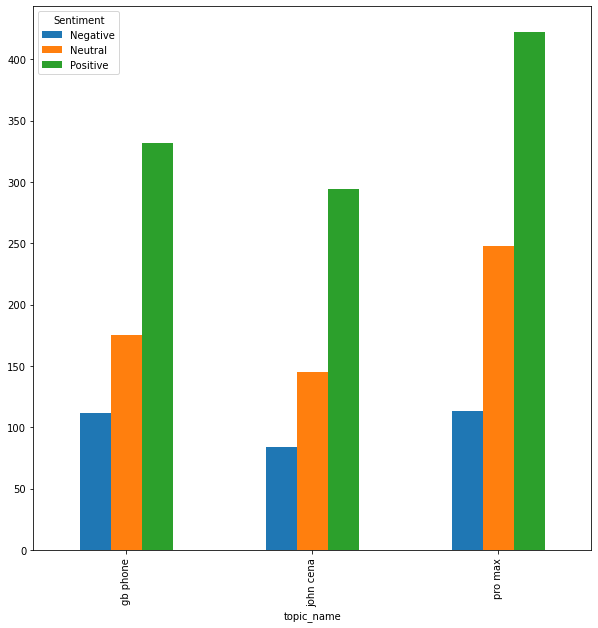

In [67]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))

# Uncomment to save the figure as a png to current directory
# fig.figure.savefig(f'{creator}_absa_lda.png' , bbox_inches='tight')